# Mini project 2

In [9]:
from data import load_dataset, filter_dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

In [10]:
# Import dataset
X_full,y_full = load_dataset()
X,y = filter_dataset(X_full,y_full,"1,7")
X = X / 255
print(X.shape)
print(y.shape)

(15170, 784)
(15170,)


In [11]:
max(X_full[0]), max(X[0])

(np.int64(255), np.float64(1.0))

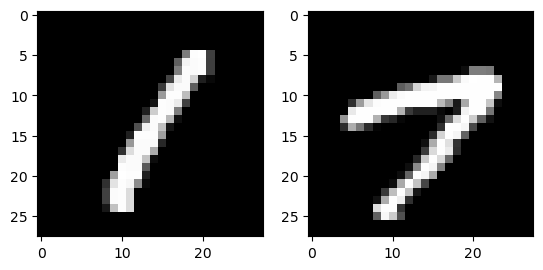

In [12]:
# Plot the squared images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X[0].reshape(28,28), cmap='gray')
ax[1].imshow(X[45].reshape(28,28), cmap='gray')
plt.show()

In [13]:
# Perform PCA on the dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print("Total variance capture by PCA: ", sum(pca.explained_variance_ratio_))
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

Total variance capture by PCA:  0.36851488459766074


Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

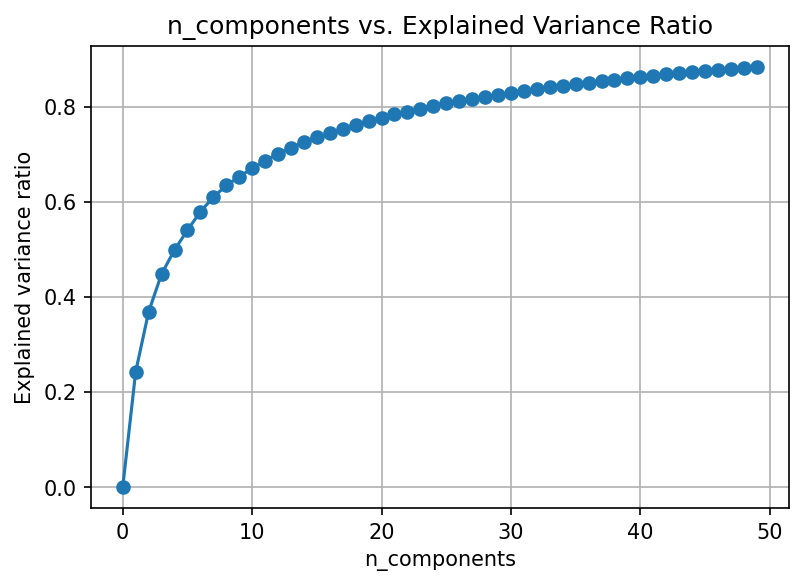

In [14]:
# Study effect of n_components on explained variance ratio
nums = np.arange(50)
 
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  X_pca = pca.fit_transform(X)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(6,4),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [15]:
# LDA proves to be much better, since we care more about class separation and nor variance
lda = LinearDiscriminantAnalysis(n_components=1)
Xs = StandardScaler().fit_transform(X)
X_lda = lda.fit_transform(Xs, y)
print("Total variance capture by LDA: ", sum(lda.explained_variance_ratio_))
print("New feature-space shape: ", X_lda.shape)

Total variance capture by LDA:  1.0
New feature-space shape:  (15170, 1)


In [20]:
# Plot LDA
# Scatter plot along a single axis (1D)
plt.figure(figsize=(8, 5))
sns.kdeplot(x=X_lda.ravel(), hue=y, fill=True, palette=['blue', 'red'])
plt.xlabel("LDA Feature")
plt.ylabel("Density")
plt.title("LDA Feature Distribution by Class")
plt.legend(["Digit 1", "Digit 7"])
plt.show()

AttributeError: module 'seaborn' has no attribute 'kdeplot'

<Figure size 800x500 with 0 Axes>

Query-by-Committee (parrallel) <br>
heavily pased on exercise8 solution <br>
Should be seperated into a different file, so only the bottom cell is needed

In [ ]:
import sys
#!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install modAL
!{sys.executable} -m pip install modal

from modAL.disagreement import vote_entropy_sampling
from modAL.models import ActiveLearner, Committee

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

################################################################################
#             Something with the Modal installation seems broken.              #
#           Please email support@modal.com and we will try to help!            #
################################################################################



ModuleNotFoundError: No module named 'modal'

In [29]:
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
import itertools as it
from sklearn.model_selection import train_test_split
from collections import namedtuple
from tqdm.notebook import tqdm, trange

ModelClass=RandomForestClassifier
SEED = 1 # Set our RNG seed for reproducibility.

n_queries = 75 # You can lower this to decrease run time

# You can increase this to get error bars on your evaluation.
# You probably need to use the parallel code to make this reasonable to compute
n_repeats = 3

ResultsRecord = namedtuple('ResultsRecord', ['estimator', 'query_id', 'score'])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_lda, y, test_size=1/3, random_state=SEED)

# in case repetitions are desired
permutations=[np.random.permutation(X_train.shape[0]) for _ in range(n_repeats)]


In [30]:
# PARRALLEL VERSION OF THE CELL ABOVE
# Use this instead if you aren't afraid of working with parallel code or want to learn.

n_members=[2, 4, 8, 16]

def train_committee(i_repeat, i_members, X_train, y_train):
    committee_results = []
    print('') # progress bars won't be displayed if not included

    X_pool = X_train.copy()
    y_pool = y_train.copy()

    start_indices = permutations[i_repeat][:1]

    committee_members = [ActiveLearner(estimator=ModelClass(),
                                       X_training=X_train[start_indices, :],
                                       y_training=y_train[start_indices],
                                       ) for _ in range(i_members)]

    committee = Committee(learner_list=committee_members,
                          query_strategy=vote_entropy_sampling)

    X_pool = np.delete(X_pool, start_indices, axis=0)
    y_pool = np.delete(y_pool, start_indices)

    for i_query in tqdm(range(1, n_queries), desc=f'Round {i_repeat} with {i_members} members', leave=False):
        query_idx, query_instance = committee.query(X_pool)

        committee.teach(
            X=X_pool[query_idx].reshape(1, -1),
            y=y_pool[query_idx].reshape(1, )
        )
        committee._set_classes() #this is needed to update for unknown class labels

        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)

        score = committee.score(X_test, y_test)

        committee_results.append(ResultsRecord(
            f'committe_{i_members}',
            i_query,
            score))

    return committee_results


result = Parallel(n_jobs=-1)(delayed(train_committee)(i,i_members,X_train,y_train)
                    for i, i_members in it.product(range(n_repeats), n_members))

print('All jobs done')
committee_results=[r for rs in result for r in rs]


NameError: name 'ActiveLearner' is not defined

In [ ]:
df_results = pd.concat([pd.DataFrame(results)
                        for results in
                        [committee_results]])
df_results.head()